In [1]:
# Standard imports & helper functions
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Try cvxpy — if unavailable, we'll fallback to analytic solution
try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except Exception:
    CVXPY_AVAILABLE = False

# default plot style
plt.rcParams.update({"figure.figsize": (10,6), "font.size": 12})

@dataclass
class Params:
    a: float = 200.0
    b: float = 1.2
    d: float = 0.001  # coefficient for non-convex term (adjustable)
    p_min: float = 0.0
    p_max: float = 150.0
    capacity: float = 500.0  # optional capacity constraint (units)
    
params = Params()

In [2]:
# Convex model: analytic solution and CVXPY (if available)
a, b = params.a, params.b
p_min, p_max = params.p_min, params.p_max

# Analytic unconstrained optimum: set derivative 0 => a - 2 b p = 0 => p* = a/(2b)
p_star_analytic = a / (2.0 * b)

# Clip to bounds
p_star_clipped = float(np.clip(p_star_analytic, p_min, p_max))
revenue_analytic = lambda p: p * (a - b * p)

print("Analytic optimum (unclipped):", p_star_analytic)
print("Analytic optimum (clipped to bounds):", p_star_clipped)
print("Revenue at clipped analytic optimum:", revenue_analytic(p_star_clipped))

# CVXPY solve (maximize revenue) if available
if CVXPY_AVAILABLE:
    p = cp.Variable()
    demand = a - b * p
    revenue = p * demand
    # Because CVXPY follows DCP, we express objective as Maximize(revenue) but
    # p * demand = a*p - b*p^2 which is concave in p, so CVXPY accepts concave objective in Maximize.
    obj = cp.Maximize(revenue)
    constraints = [p >= p_min, p <= p_max, demand >= 0]
    prob = cp.Problem(obj, constraints)
    prob.solve()
    print("\nCVXPY solve status:", prob.status)
    print("CVXPY p*:", float(p.value))
    print("CVXPY revenue at p*:", float((p.value * (a - b * p.value))))
else:
    print("\ncvxpy not available: skipped CVXPY solve (analytic solution used).")


Analytic optimum (unclipped): 83.33333333333334
Analytic optimum (clipped to bounds): 83.33333333333334
Revenue at clipped analytic optimum: 8333.333333333334

cvxpy not available: skipped CVXPY solve (analytic solution used).


In [7]:
# Non-convex model: R_nc(p) = p*(a - b p + d p^3) = a p - b p^2 + d p^4
a, b, d = params.a, params.b, params.d
p_vals = np.linspace(p_min, p_max, 500)

def revenue_nonconvex(p):
    return p * (a - b * p + d * p**3)

rev_nc = revenue_nonconvex(p_vals)

# grid search to find local maxima and global maximum within bounds
from scipy.signal import argrelmax

# find local maxima indexes (requires SciPy). If SciPy not installed, fallback to simple local check
try:
    local_max_idx = argrelmax(rev_nc)[0]
    local_max_idx = local_max_idx.tolist()
except Exception:
    # fallback: simple discrete neighbors check
    local_max_idx = [i for i in range(1, len(rev_nc)-1) if rev_nc[i] > rev_nc[i-1] and rev_nc[i] > rev_nc[i+1]]

local_maxima = [(p_vals[i], rev_nc[i]) for i in local_max_idx]
global_idx = int(np.argmax(rev_nc))
global_max = (p_vals[global_idx], rev_nc[global_idx])

print("Found local maxima (price, revenue):")
for p_m, r_m in local_maxima[:10]:
    print(f"  p={p_m:.3f}, R={r_m:.3f}")
print("Global maximum from grid search:", f"p={global_max[0]:.3f}, R={global_max[1]:.3f}")


Found local maxima (price, revenue):
Global maximum from grid search: p=150.000, R=509250.000


In [8]:
# Restored convex: back to R(p) = a p - b p^2 (same as analytic)
# We compute revenue across price grid for plotting
prices = np.linspace(p_min, p_max, 500)
rev_original = prices * (a - b * prices)
rev_restored = rev_original.copy()  # same shape; demonstrates restoration

# If you want, show a convexified transformation (e.g., log-demand model) - optional
def revenue_log(p, a_log=200.0, b_log=1.0):
    # Example: demand = a_log * exp(-b_log * p) -> revenue = p * a_log * exp(-b_log * p)
    return p * a_log * np.exp(-b_log * p / a)  # arbitrary scaling to keep magnitudes reasonable

rev_log_example = revenue_log(prices)


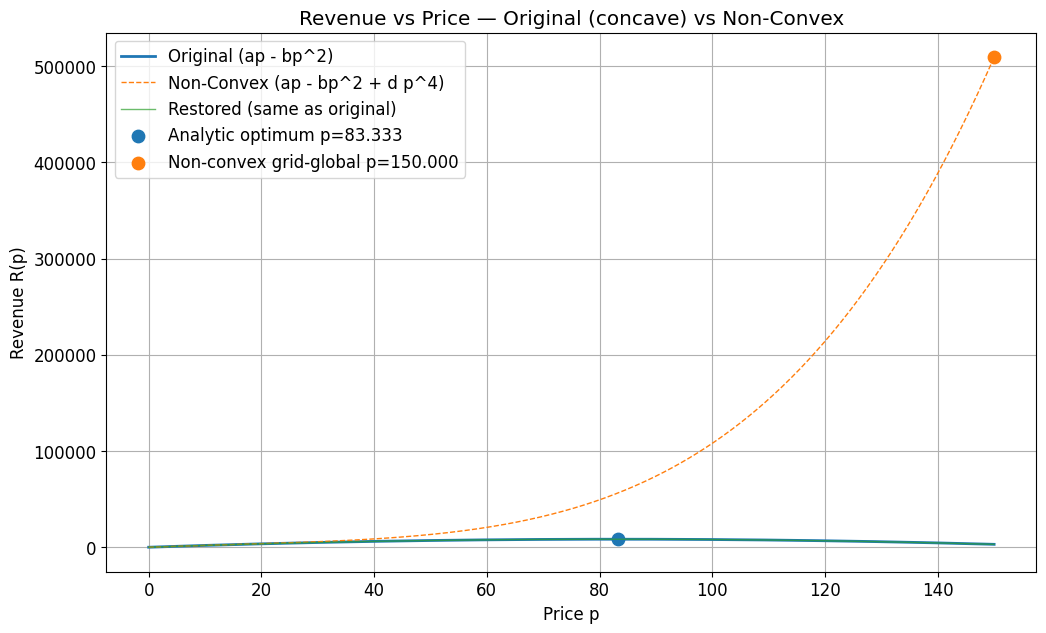

In [9]:
plt.figure(figsize=(12,7))
plt.plot(prices, rev_original, label="Original (ap - bp^2)", linewidth=2)
plt.plot(p_vals, rev_nc, label="Non-Convex (ap - bp^2 + d p^4)", linewidth=1, linestyle='--')
plt.plot(prices, rev_restored, label="Restored (same as original)", linewidth=1, alpha=0.7)
plt.scatter([p_star_clipped], [revenue_analytic(p_star_clipped)], color='C0', s=80, label=f"Analytic optimum p={p_star_clipped:.3f}")
# global optimum for non-convex
plt.scatter([global_max[0]], [global_max[1]], color='C1', s=80, label=f"Non-convex grid-global p={global_max[0]:.3f}")
# local maxima markers
for p_m, r_m in local_maxima:
    plt.scatter([p_m], [r_m], color='gray', s=30, alpha=0.6)
plt.xlabel("Price p")
plt.ylabel("Revenue R(p)")
plt.title("Revenue vs Price — Original (concave) vs Non-Convex")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Optional: use scipy.optimize to find local maxima by starting from multiple seeds
try:
    from scipy.optimize import minimize

    def neg_rev_nc(p_scalar):
        p = float(p_scalar[0])
        # enforce bounds by returning large positive value if out of bounds
        if p < p_min or p > p_max:
            return 1e9
        return -revenue_nonconvex(p)

    seeds = np.linspace(p_min + 1e-3, p_max - 1e-3, 10)
    opt_results = []
    for s in seeds:
        res = minimize(neg_rev_nc, x0=[s], bounds=[(p_min, p_max)])
        if res.success:
            p_opt = float(res.x[0])
            r_opt = revenue_nonconvex(p_opt)
            opt_results.append((p_opt, r_opt))
    # deduplicate close solutions
    unique_opts = {}
    for p_opt, r_opt in opt_results:
        key = round(p_opt, 4)
        unique_opts[key] = (p_opt, r_opt)
    unique_opts = sorted(unique_opts.values(), key=lambda x: -x[1])
    print("Local maxima from scipy.optimize (sorted by revenue):")
    for p_opt, r_opt in unique_opts:
        print(f" p={p_opt:.4f}, R={r_opt:.4f}")
except Exception as e:
    print("scipy.optimize not available or failed; skipped numerical optimization. Error:", e)

Local maxima from scipy.optimize (sorted by revenue):
 p=150.0000, R=509250.0000
